In [1]:
import os
import torch
import numpy as np
import pandas as pd
from anndata import AnnData
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

## Reading spatial dataset

In [3]:
path = "/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/"

In [5]:
RNA_data = pd.read_csv(path + 'P22_counts/P22_rna_counts.txt', sep='\t', index_col=0)
X1 = RNA_data.T
(n1, d1) = X1.shape
ATAC_data = pd.read_csv(path + 'P22_counts/P22_peak_counts.txt', sep='\t', index_col=0)
X2 = ATAC_data.T
(n2, d2) = X2.shape
spatial = pd.read_csv(path + "P22_counts/Spots.coords.tsv.gz",sep='\t', index_col=0, header=None)
spatial = np.array(spatial)

In [7]:
RNA_data

,CTAAGGTCTTGCTGGA,CTAAGGTCACACAGAA,CTAAGGTCACAGCAGA,CTAAGGTCACCTCCAA,CTAAGGTCACGCTCGA,CTAAGGTCACGTATCA,CTAAGGTCACTATGCA,CTAAGGTCAGAGTCAA,CTAAGGTCAGATCGCA,CTAAGGTCAGCAGGAA,...,GAACAGGCCGGATTGC,GAACAGGCCTAAGGTC,GAACAGGCGAACAGGC,GAACAGGCGACAGTGC,GAACAGGCGAGTTAGC,GAACAGGCGATGAATC,GAACAGGCGCCAAGAC,GAACAGGCCGGAAGAA,GAACAGGCGTGACAAG,GAACAGGCGAACCAGA
Gm26752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ppp1r14c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plekhg1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mthfd1l,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Akap12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uty,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ddx3y,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
Gm20775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm21857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
spatial

,1,2
0,,
CTAAGGTCTTGCTGGA,0.0,91.0
CTAAGGTCACACAGAA,82.0,91.0
CTAAGGTCACAGCAGA,81.0,91.0
CTAAGGTCACCTCCAA,80.0,91.0
CTAAGGTCACGCTCGA,79.0,91.0
...,...,...
GAACAGGCGATGAATC,5.0,92.0
GAACAGGCGCCAAGAC,4.0,92.0
GAACAGGCCGGAAGAA,3.0,92.0


In [ ]:
adata_RNA = AnnData(X1)
adata_RNA.obs['batch'] = ['RNA'] * n1
adata_RNA.obsm['spatial'] = spatial

In [6]:
adata_ATAC = AnnData(X2)
adata_ATAC.obs['batch'] = ['ATAC'] * n2
adata_ATAC.obsm['spatial'] = spatial

## RNA analysis
建成anndata，然后使用GraphST重构表示，用于后续的分析

In [7]:
adata = adata_RNA.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=5000)
# adata.var['highly_variable'] = True
sc.pp.scale(adata)
adata

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


AnnData object with n_obs × n_vars = 9215 × 18005
    obs: 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [8]:
highly_variable = list(adata.var[adata.var["highly_variable"]==True].index)
len(highly_variable)

5000

In [9]:
sc.tl.pca(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 9215 × 18005
    obs: 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

In [11]:
new_adata = AnnData(adata.obsm["X_pca"]).copy()
new_adata.obs['batch'] = ['RNA'] * n1
new_adata.obsm['spatial'] = spatial
new_adata.var['highly_variable'] = True
new_adata

AnnData object with n_obs × n_vars = 9215 × 50
    obs: 'batch'
    var: 'highly_variable'
    obsm: 'spatial'

### Train the GraphST model

In [12]:
# define model
model = GraphST.GraphST(new_adata, device="cuda:6")

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:06<00:00, 97.58it/s] 

Optimization finished for ST data!


After model training, the learned representations will be saved in adata.obsm[‘emb’], and can be used for spatial clustering.

In [13]:
adata

AnnData object with n_obs × n_vars = 9215 × 50
    obs: 'batch'
    var: 'highly_variable'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [14]:
adata.obsm['emb'].shape

(9215, 50)

### Spatial clustering

重构的RNA数据聚类

In [15]:
data_aligned = adata.obsm['emb']
adata_aligned = AnnData(data_aligned).copy()
adata_aligned.obs['batch'] = ['RNA'] * n1
adata_aligned.obsm['spatial'] = spatial
# sc.pp.scale(adata_aligned)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


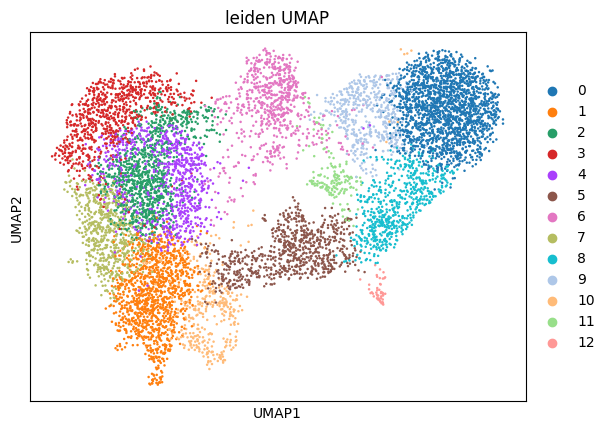

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


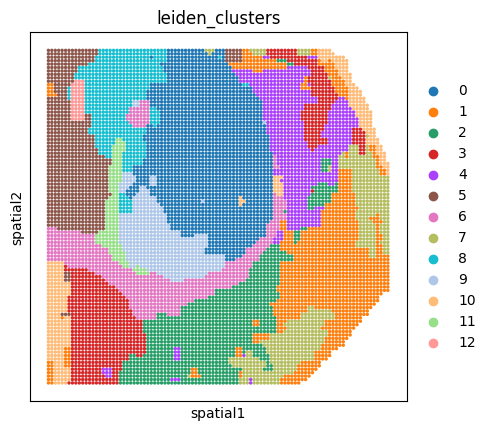

In [16]:
sc.tl.leiden(adata_aligned, key_added='leiden_clusters',resolution=1.2)
sc.pl.umap(adata_aligned, color = 'leiden_clusters', title='leiden UMAP')
sc.pl.spatial(adata_aligned, img_key=None, color="leiden_clusters",spot_size = 1)

In [ ]:
# adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_P22brain/output/P22rna_rec_adata.h5ad")

Text(0.5, 1.0, 'snn of RNA')

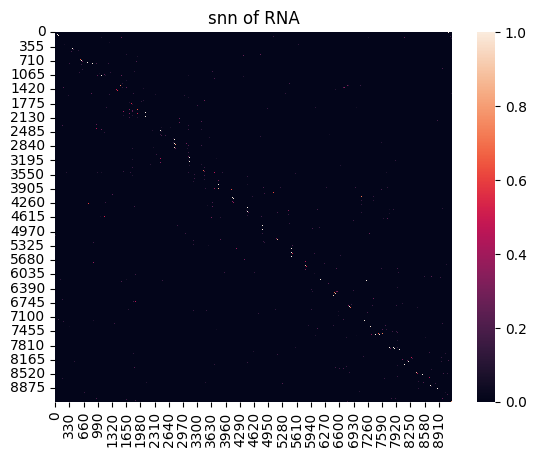

In [17]:
n = n2
snn = adata_aligned.obsp['connectivities'].todense()
snn = np.array(snn)
snn[range(n), range(n)] = 1

import seaborn as sns
import matplotlib.pylab as pl
sns.heatmap(snn)
pl.title('snn of RNA')

In [ ]:
# # 存储SNN
# df = pd.DataFrame(snn, index = adata_RNA.obs_names, columns = adata_RNA.obs_names)
# df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_P22brain/output/P22rna_snn.txt', index=True)
# df

RNA的低维嵌入数据的聚类

In [18]:
hiden_feat = model.hiden_feat #低维嵌入
latent = hiden_feat.cpu()
latent = latent.detach().numpy()
latent

array([[ 0.62901294,  1.1540884 ,  0.12768981, ...,  0.8657298 ,
        -0.43092677, -1.2801533 ],
       [ 2.409339  ,  0.04388244, -4.2702723 , ...,  0.2696981 ,
         3.1053925 , -4.9917674 ],
       [ 3.9321024 , -0.28139308, -4.002824  , ...,  2.4084954 ,
         1.0535381 , -4.745222  ],
       ...,
       [-2.2422698 ,  2.01248   , -1.2789375 , ...,  1.7717203 ,
        -4.8079047 ,  2.2121117 ],
       [ 0.6425055 , -0.1390906 , -1.7245544 , ...,  1.8999972 ,
        -0.81962246,  1.1175519 ],
       [-1.1567014 , -0.3895929 , -1.0224917 , ...,  0.48022008,
         0.46177337,  0.03923482]], dtype=float32)

In [19]:
data_aligned = latent
adata_aligned = AnnData(latent).copy()
adata_aligned.obs['batch'] = ['ATAC'] * n2
adata_aligned.obsm['spatial'] = spatial
sc.pp.scale(adata_aligned)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


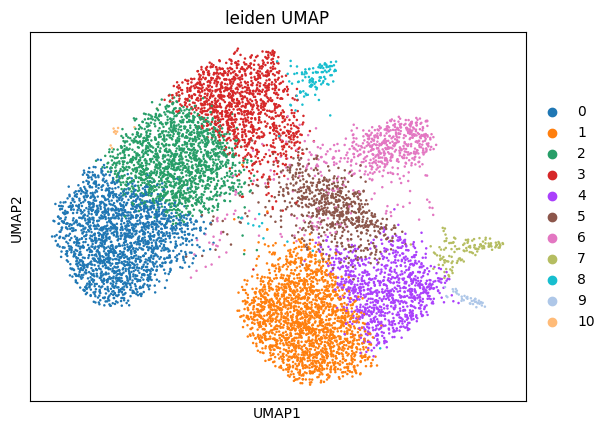

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


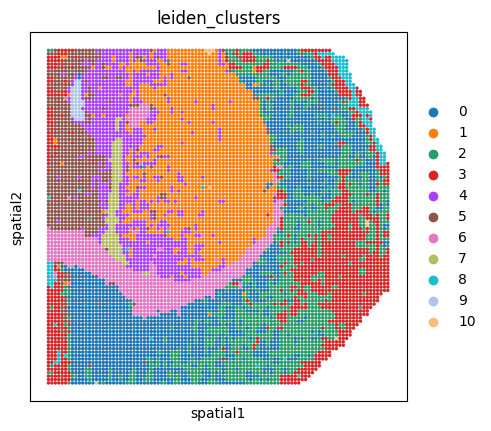

In [20]:
sc.tl.leiden(adata_aligned, key_added='leiden_clusters',resolution=1.2)
sc.pl.umap(adata_aligned, color = 'leiden_clusters', title='leiden UMAP')
sc.pl.spatial(adata_aligned, img_key=None, color="leiden_clusters",spot_size = 1)

## ATAC analysis

In [21]:
adata = adata_ATAC.copy()
adata

AnnData object with n_obs × n_vars = 9215 × 121068
    obs: 'batch'
    obsm: 'spatial'

In [22]:
import scglue
scglue.data.lsi(adata, n_components=50, n_iter=15)

In [23]:
adata.obsm["X_lsi"].shape

(9215, 50)

In [24]:
new_adata = AnnData(adata.obsm["X_lsi"]).copy()
new_adata.obs['batch'] = ['ATAC'] * n2
new_adata.obsm['spatial'] = spatial
new_adata.var['highly_variable'] = True
new_adata

AnnData object with n_obs × n_vars = 9215 × 50
    obs: 'batch'
    var: 'highly_variable'
    obsm: 'spatial'

### Train the GraphST model

In [25]:
# define model
model = GraphST.GraphST(new_adata, device="cuda:7")

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:06<00:00, 96.31it/s]

Optimization finished for ST data!


In [26]:
adata

AnnData object with n_obs × n_vars = 9215 × 50
    obs: 'batch'
    var: 'highly_variable'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

After model training, the learned representations will be saved in adata.obsm[‘emb’], and can be used for spatial clustering.

In [27]:
adata.obsm['emb'].shape

(9215, 50)

### Spatial clustering

重构的ATAC数据聚类

In [28]:
data_aligned = adata.obsm['emb']
adata_aligned = AnnData(data_aligned).copy()
adata_aligned.obs['batch'] = ['ATAC'] * n2
adata_aligned.obsm['spatial'] = spatial
# sc.pp.scale(adata_aligned)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


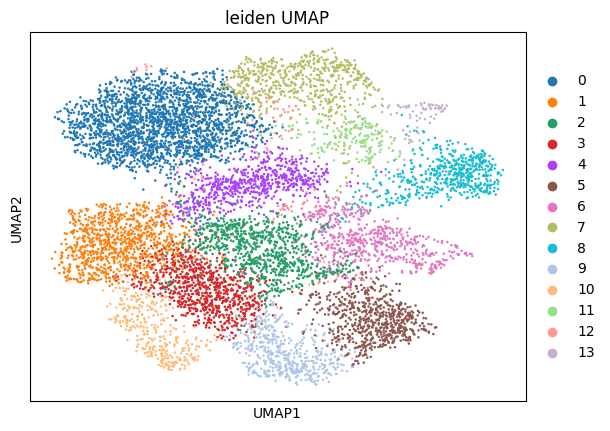

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


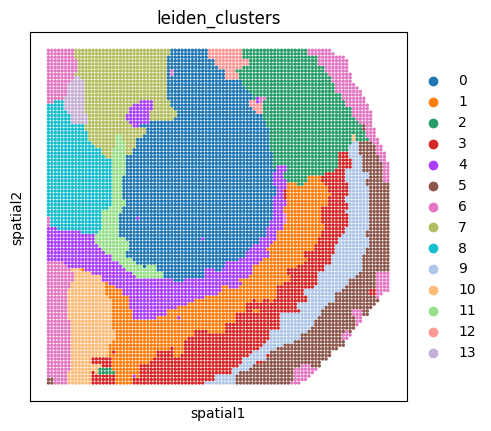

In [29]:
sc.tl.leiden(adata_aligned, key_added='leiden_clusters',resolution=0.9)
sc.pl.umap(adata_aligned, color = 'leiden_clusters', title='leiden UMAP')
sc.pl.spatial(adata_aligned, img_key=None, color="leiden_clusters",spot_size = 1)

In [ ]:
# adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_P22brain/output/P22atac_rec_adata.h5ad")

Text(0.5, 1.0, 'snn of ATAC')

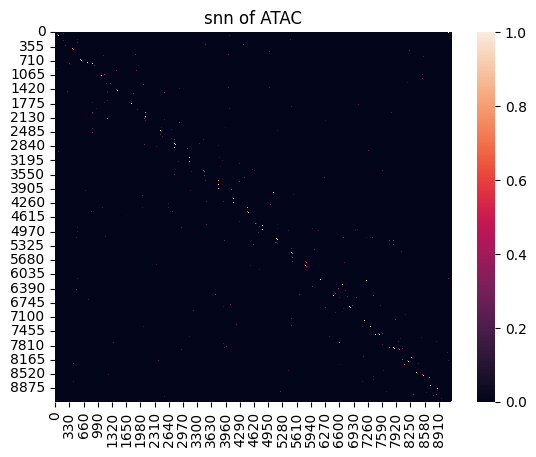

In [30]:
n = n2
snn = adata_aligned.obsp['connectivities'].todense()
snn = np.array(snn)
snn[range(n), range(n)] = 1

import seaborn as sns
import matplotlib.pylab as pl
sns.heatmap(snn)
pl.title('snn of ATAC')

In [ ]:
# # 存储SNN
# df = pd.DataFrame(snn, index = adata_ATAC.obs_names, columns = adata_ATAC.obs_names)
# df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_P22brain/output/P22atac_snn.txt', index=True)
# df

ATAC的低维嵌入数据聚类

In [31]:
hiden_feat = model.hiden_feat #低维嵌入
latent = hiden_feat.cpu()
latent = latent.detach().numpy()
latent

array([[-3.1499796 ,  1.4433825 , -0.9665689 , ..., -0.85754883,
         0.12678988,  0.14020187],
       [-0.9074893 , -0.6522499 , -0.80998427, ..., -2.7332275 ,
        -0.23143107,  0.77124   ],
       [-0.9883377 ,  0.71296793, -0.8737812 , ..., -1.3976455 ,
        -0.8135697 ,  0.30258092],
       ...,
       [ 0.26006877, -0.6290631 ,  0.50051653, ...,  1.8098083 ,
        -1.8085496 ,  0.9104529 ],
       [ 1.2671404 ,  1.1808459 , -0.22354043, ...,  0.92087317,
        -1.0835321 ,  0.91653746],
       [-0.2837397 ,  1.1373968 ,  0.3685456 , ..., -0.5941931 ,
        -0.16661084,  0.64094985]], dtype=float32)

In [32]:
data_aligned = latent
adata_aligned = AnnData(latent).copy()
adata_aligned.obs['batch'] = ['ATAC'] * n2
adata_aligned.obsm['spatial'] = spatial
sc.pp.scale(adata_aligned)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


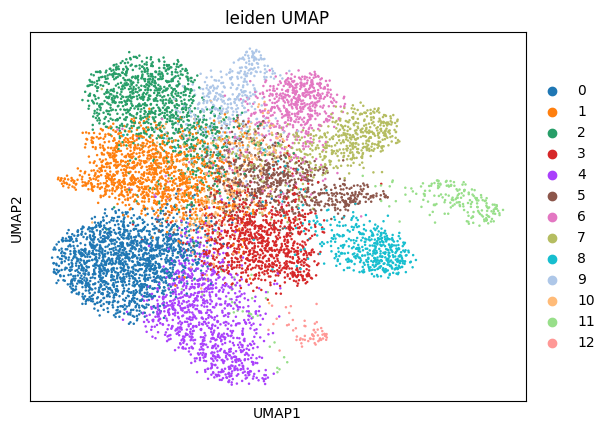

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


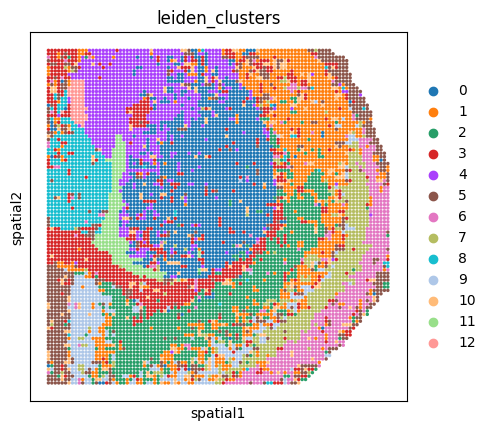

In [33]:
sc.tl.leiden(adata_aligned, key_added='leiden_clusters',resolution=1)
sc.pl.umap(adata_aligned, color = 'leiden_clusters', title='leiden UMAP')
sc.pl.spatial(adata_aligned, img_key=None, color="leiden_clusters",spot_size = 1)

读取adata

In [34]:
import anndata

In [35]:
adata_RNA = anndata.read_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_P22brain/output/P22rna_rec_adata.h5ad")
adata_RNA

AnnData object with n_obs × n_vars = 9215 × 50
    obs: 'batch', 'leiden_clusters'
    uns: 'leiden', 'leiden_clusters_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


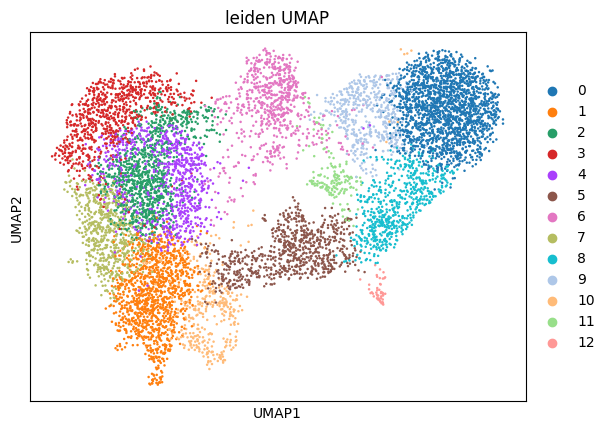

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


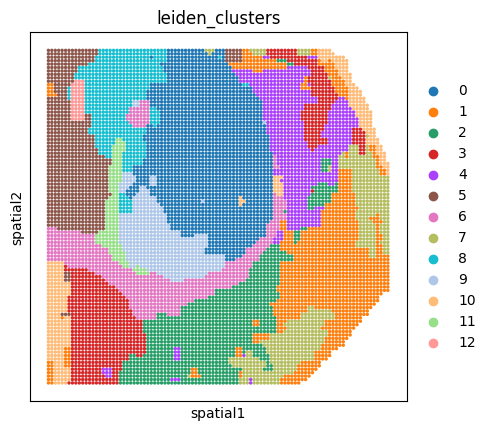

In [36]:
sc.pl.umap(adata_RNA, color = 'leiden_clusters', title='leiden UMAP')
sc.pl.spatial(adata_RNA, img_key=None, color="leiden_clusters",spot_size = 1)

In [37]:
adata_ATAC = anndata.read_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_P22brain/output/P22atac_rec_adata.h5ad")
adata_ATAC

AnnData object with n_obs × n_vars = 9215 × 50
    obs: 'batch', 'leiden_clusters'
    uns: 'leiden', 'leiden_clusters_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


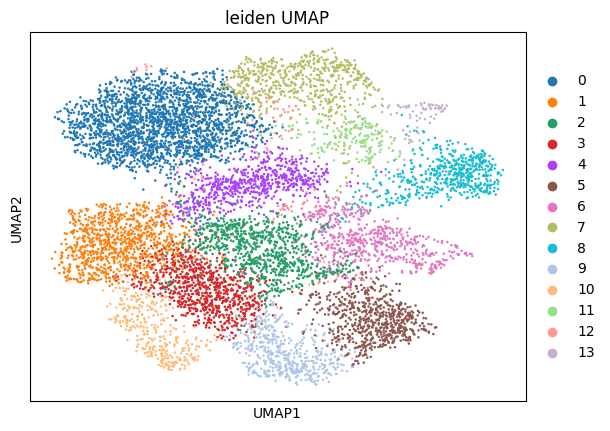

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


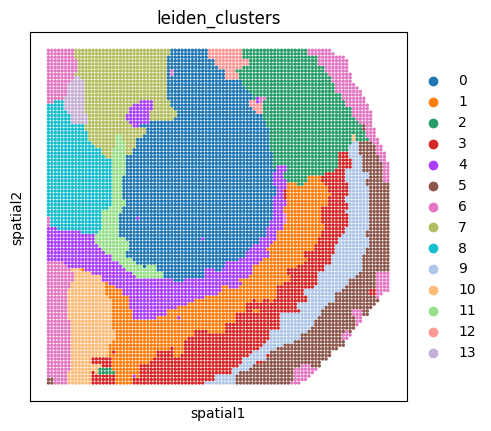

In [38]:
sc.pl.umap(adata_ATAC, color = 'leiden_clusters', title='leiden UMAP')
sc.pl.spatial(adata_ATAC, img_key=None, color="leiden_clusters",spot_size = 1)